In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
# trading packages
import bt 
import talib


In [4]:
# Expected columns:
# ['timestamp','open','high','low','close','volume']
df = pd.read_csv("../data/binance/hbar.csv", parse_dates=["time_stamp"])
df = df.sort_values("time_stamp").set_index("time_stamp")
df = df.drop('ignore', axis = 1)

In [5]:
df_daily = df.resample('1D').agg({'open':'first',
                                  'high':'max', 
                                  'low':'min',
                                  'close':'last',
                                  'volume':'sum'}).dropna()

### ADX

In [6]:
di_p = talib.PLUS_DI(df_daily['high'], df_daily['low'], df_daily['close'], timeperiod=14)
di_m = talib.MINUS_DI(df_daily['high'], df_daily['low'], df_daily['close'], timeperiod=14)
adx = talib.ADX(df_daily['high'], df_daily['low'], df_daily['close'], timeperiod=14)
df_adx = pd.DataFrame({'+di':di_p,
                    '-di':di_m,
                    'adx':adx})
df_adx.index = df_daily.index
df_adx = df_adx.dropna()

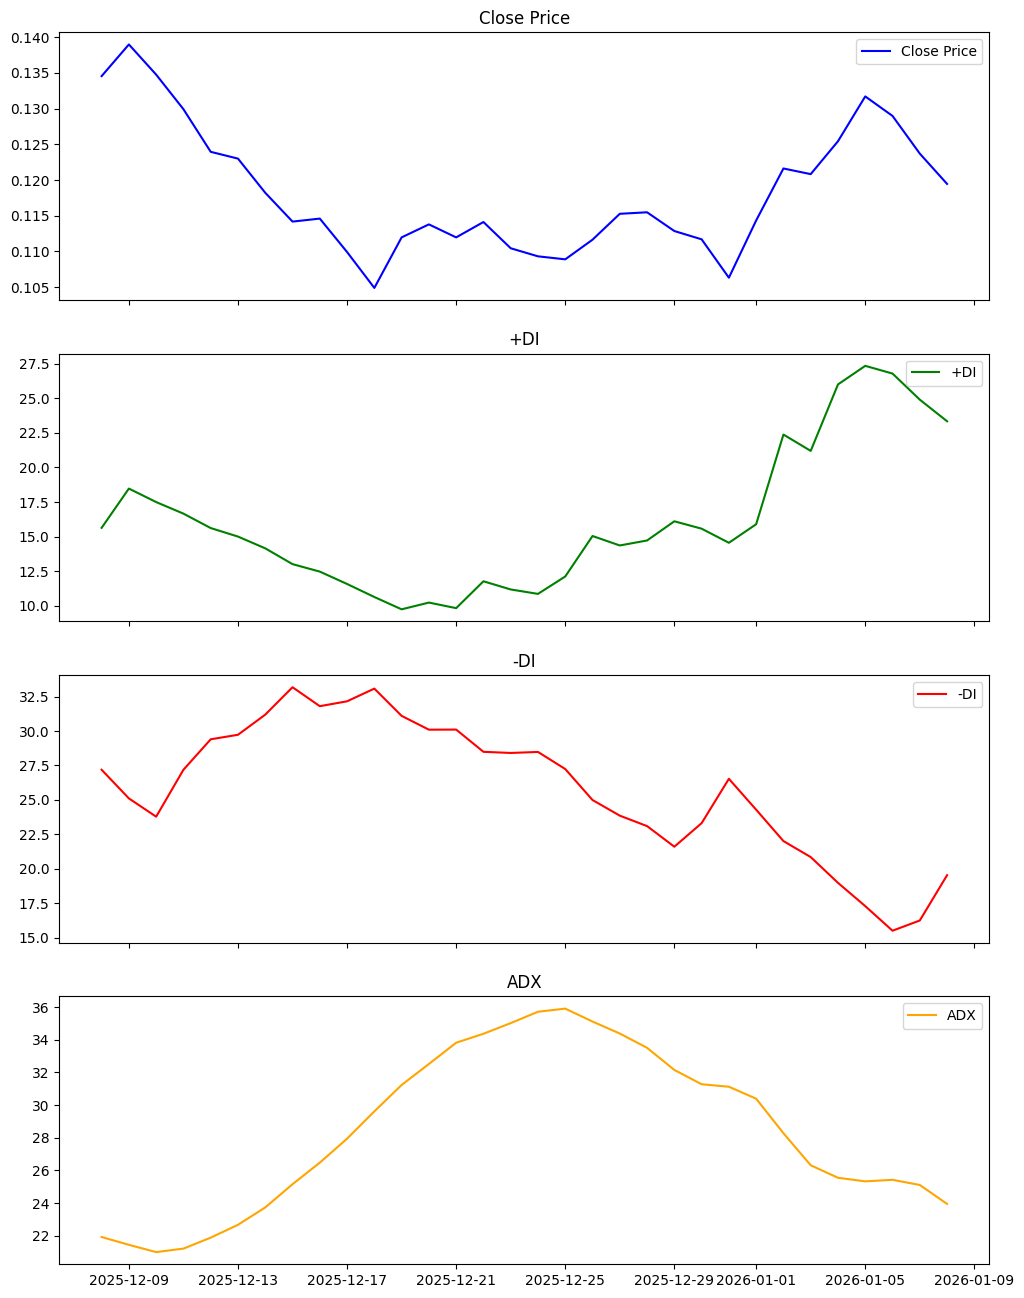

In [7]:
# subset the last three month for better visualization
df_daily_tmp = df_daily[df_daily.index >= (df_daily.index.max() - pd.DateOffset(months=1))]
df_adx_tmp = df_adx[df_adx.index >= (df_adx.index.max() - pd.DateOffset(months=1))] 
# plot close price and df_adx features in different consecutive plots
fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
axs[0].plot(df_daily_tmp.index, df_daily_tmp['close'], label='Close Price', color='blue')
axs[0].set_title('Close Price')
axs[0].legend()
axs[1].plot(df_adx_tmp.index, df_adx_tmp['+di'], label='+DI', color='green')
axs[1].set_title('+DI')
axs[1].legend()
axs[2].plot(df_adx_tmp.index, df_adx_tmp['-di'], label='-DI', color='red')
axs[2].set_title('-DI')
axs[2].legend()
axs[3].plot(df_adx_tmp.index, df_adx_tmp['adx'], label='ADX', color='orange')
axs[3].set_title('ADX')
axs[3].legend()
plt.show()

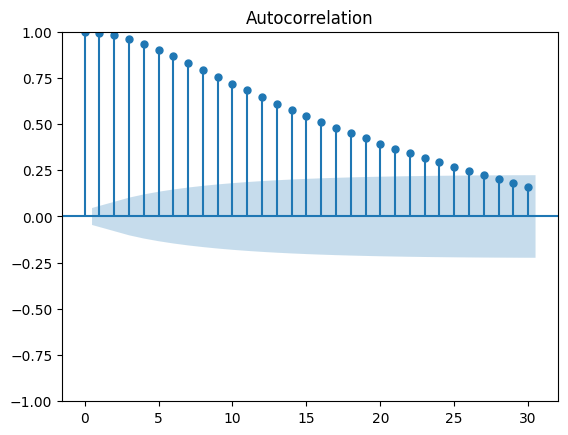

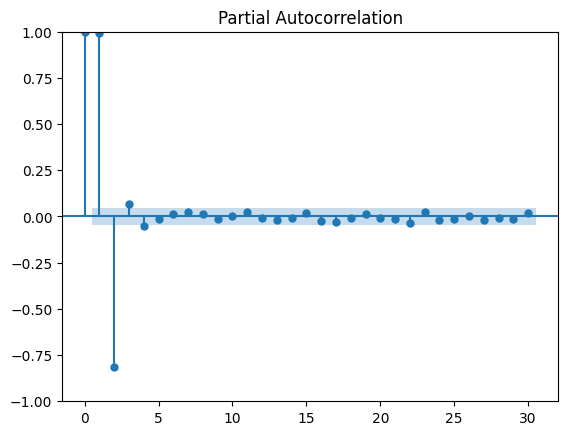

In [8]:
plot_acf(df_adx['adx'], lags=30);
plot_pacf(df_adx['adx'], lags=30);

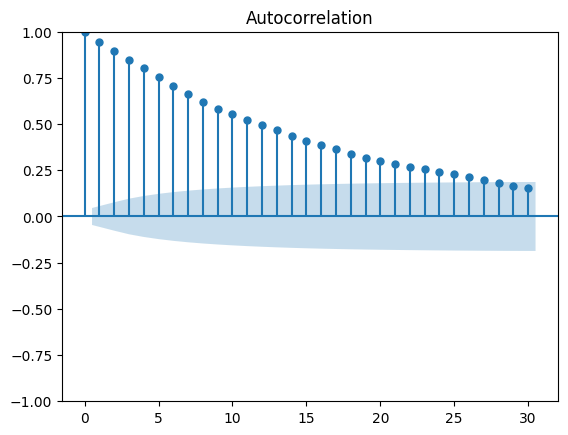

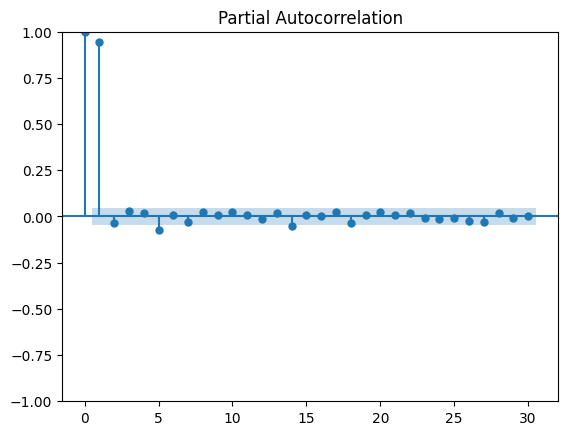

In [9]:
plot_acf(df_adx['+di'], lags=30);
plot_pacf(df_adx['+di'], lags=30);

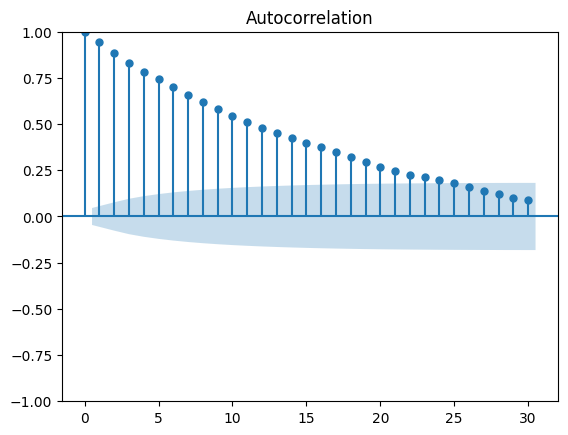

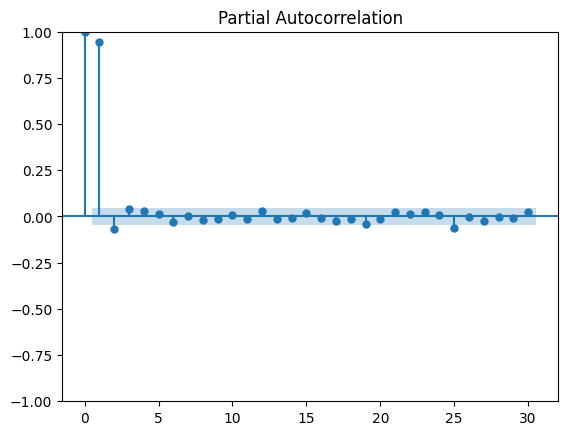

In [10]:
plot_acf(df_adx['-di'], lags=30);
plot_pacf(df_adx['-di'], lags=30);

### RSI

In [11]:
# calculate RSI
rsi = talib.RSI(df_daily['close'], timeperiod=14)
df_rsi = pd.DataFrame({'rsi':rsi})
df_rsi.index = df_daily.index

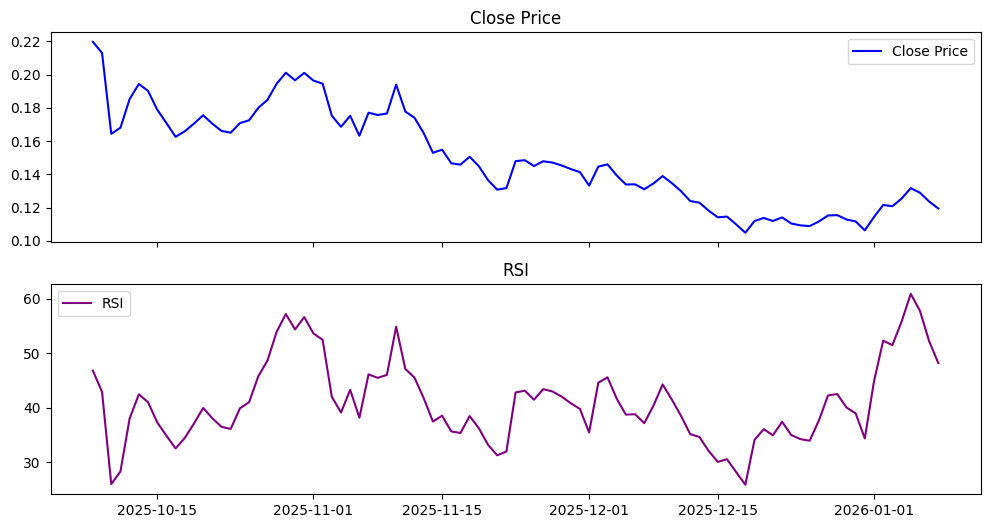

In [12]:
# subset the last three month for better visualization
df_daily_tmp = df_daily[df_daily.index >= (df_daily.index.max() - pd.DateOffset(months=3))]
df_rsi_tmp = df_rsi[df_rsi.index >= (df_rsi.index.max() - pd.DateOffset(months=3))]
# plot close price and df_adx features in different consecutive plots
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axs[0].plot(df_daily_tmp.index, df_daily_tmp['close'], label='Close Price', color='blue')
axs[0].set_title('Close Price')
axs[0].legend() 
axs[1].plot(df_rsi_tmp.index, df_rsi_tmp['rsi'], label='RSI', color='purple')
axs[1].set_title('RSI')
axs[1].legend()
plt.show()

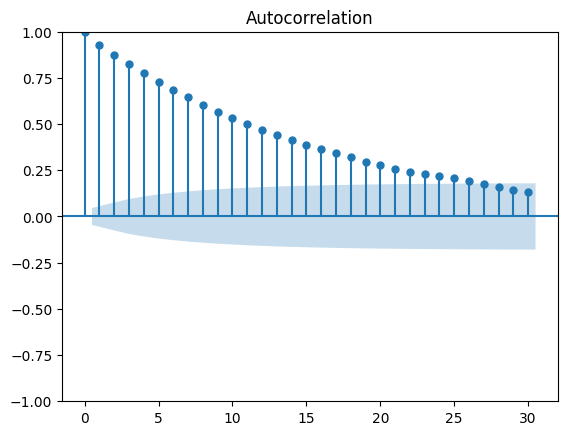

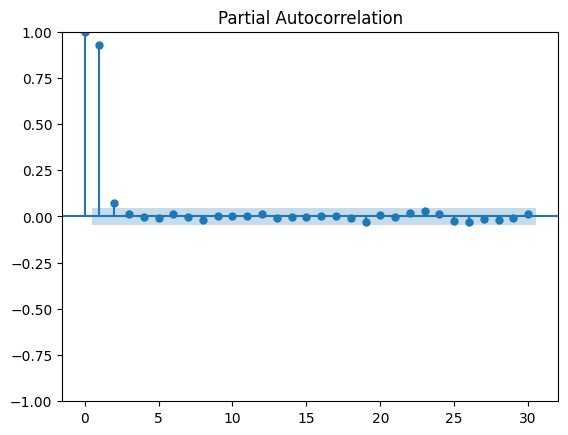

In [13]:
df_rsi = df_rsi.dropna()
plot_acf(df_rsi['rsi'], lags=30);
plot_pacf(df_rsi['rsi'], lags=30);

### Bollinger Band

In [14]:
# calculate Bollinger Bands
upper, middle, lower = talib.BBANDS(df_daily['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
df_bb = pd.DataFrame({'upper':upper,
                      'middle':middle,
                      'lower':lower})
df_bb.index = df_daily.index
df_bb = df_bb.dropna()

# calculate bandwidth and %b for analysis
df_bb['bandwidth'] = (df_bb['upper'] - df_bb['lower']) / df_bb['middle']
df_bb['percent_b'] = (df_daily['close'] - df_bb['lower']) / (df_bb['upper'] - df_bb['lower'])

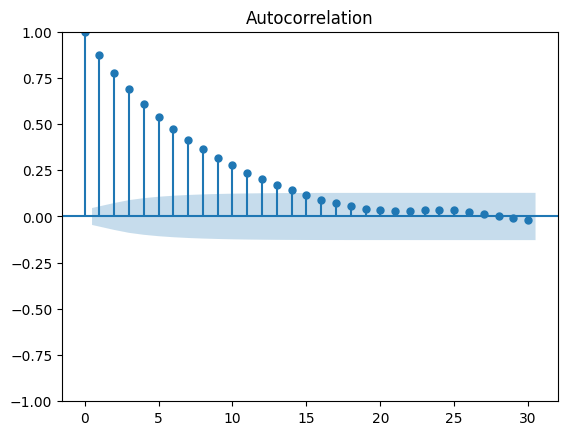

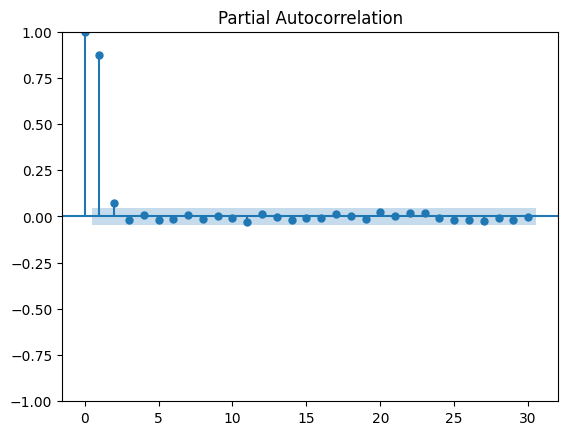

In [15]:
plot_acf(df_bb['percent_b'].dropna(), lags=30);
plot_pacf(df_bb['percent_b'].dropna(), lags=30);

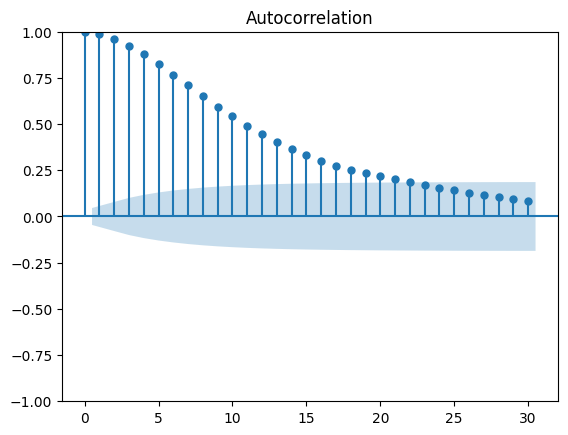

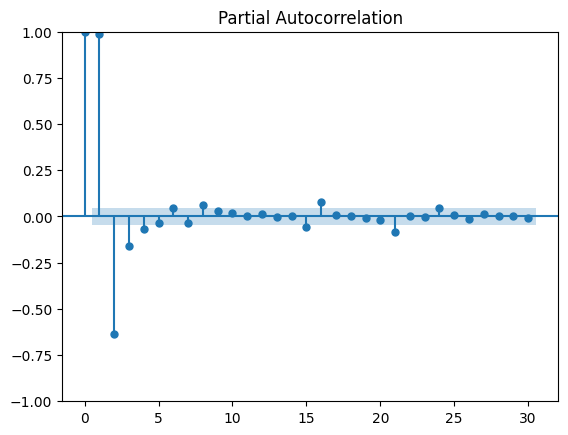

In [16]:
plot_acf(df_bb['bandwidth'].dropna(), lags=30);
plot_pacf(df_bb['bandwidth'].dropna(), lags=30);

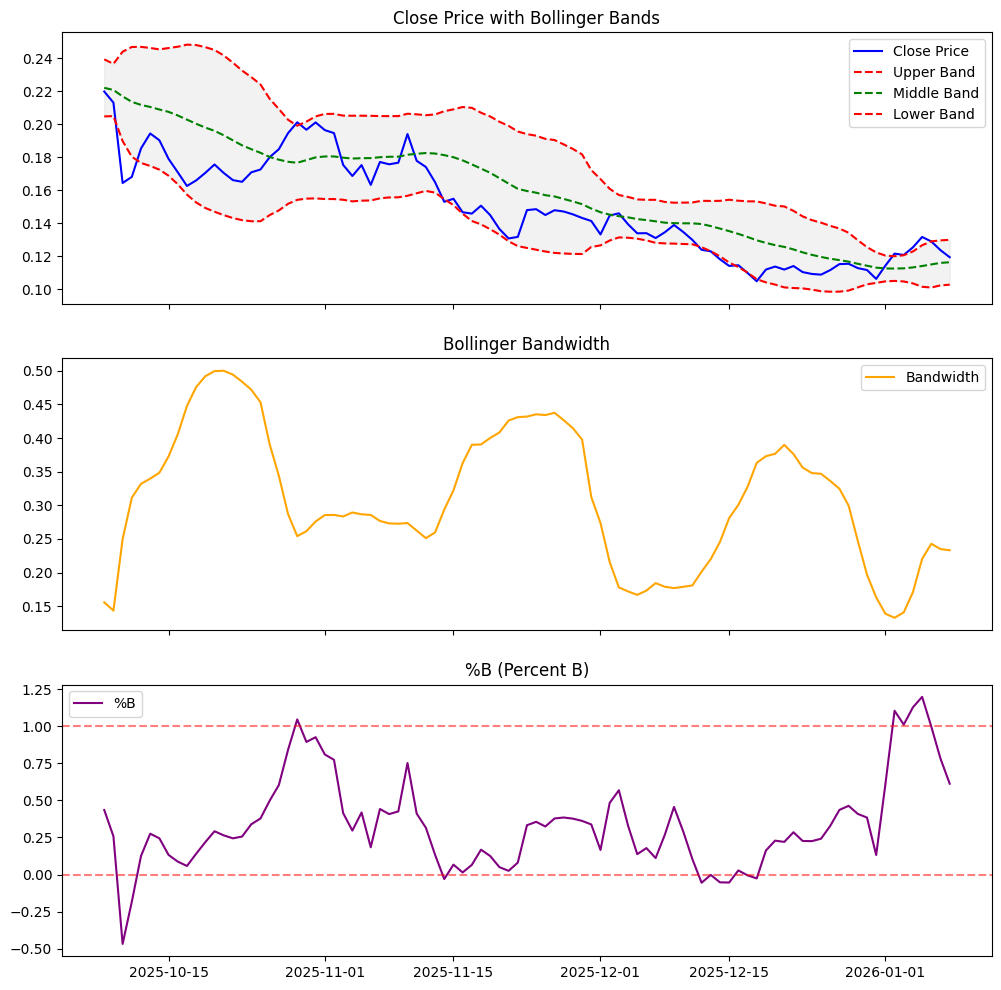

In [17]:
# subset the last three month for better visualization
df_daily_tmp = df_daily[df_daily.index >= (df_daily.index.max() - pd.DateOffset(months=3))]
df_bb_tmp = df_bb[df_bb.index >= (df_bb.index.max() - pd.DateOffset(months=3))]

# plot close price with Bollinger Bands
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axs[0].plot(df_daily_tmp.index, df_daily_tmp['close'], label='Close Price', color='blue')
axs[0].plot(df_bb_tmp.index, df_bb_tmp['upper'], label='Upper Band', color='red', linestyle='--')
axs[0].plot(df_bb_tmp.index, df_bb_tmp['middle'], label='Middle Band', color='green', linestyle='--')
axs[0].plot(df_bb_tmp.index, df_bb_tmp['lower'], label='Lower Band', color='red', linestyle='--')
axs[0].fill_between(df_bb_tmp.index, df_bb_tmp['lower'], df_bb_tmp['upper'], alpha=0.1, color='gray')
axs[0].set_title('Close Price with Bollinger Bands')
axs[0].legend()
axs[1].plot(df_bb_tmp.index, df_bb_tmp['bandwidth'], label='Bandwidth', color='orange')
axs[1].set_title('Bollinger Bandwidth')
axs[1].legend()
axs[2].plot(df_bb_tmp.index, df_bb_tmp['percent_b'], label='%B', color='purple')
axs[2].axhline(y=1, color='r', linestyle='--', alpha=0.5)
axs[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axs[2].set_title('%B (Percent B)')
axs[2].legend()
plt.show()